# Testing Conductor Fields in Presence of MR

#### Notebook provides examples of:
- Setting up multiple, overlapping mesh refinement patches
- Making manual lineout plots of field data
- Making a manual plot of conductors on domain (see ConductorPlots for automatic functionality)
- Use of lineout widget for field/potential plots

#### Simulation Description
Simulation domain is x=120 nm by z=10,000 nm. The grid is included as a single post which is grid_z=100 nm by grid_x=12 nm. The conductor at the top of the grid is z=10 by x=12 nm, only this conductor influences the field solve, however, the whole grid structure will act as a particle sink, as will the cathode and anode. 

Grid Voltage = 20.0 V

Anode Voltage = -0.5 V

Lineouts are plotted in representation of the simulation domain along with mesh refinement patches. 
Example line plots are shown for Ex(x) and Ez(z) on parent solver and child MR patches.

In [1]:
% matplotlib notebook 

In [2]:
from __future__ import division
import sys
del sys.argv[1:] #  Necessry to run 'from warp import *' in IPython notebook without conflict.
from warp import * 
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from re import findall
from datetime import datetime
from scipy.special import erfinv
from warp.data_dumping.openpmd_diag import ParticleDiagnostic
from rswarp.diagnostics import FieldDiagnostic
from rswarp.diagnostics.plotting import FieldLineout
from rswarp.utilities.file_utils import cleanupPrevious
from warp.particles.singleparticle import TraceParticle

# Warp
# Origin date: Mon, 30 Oct 2017 15:43:58 -0700
# Local date: Mon, 30 Oct 2017 15:43:58 -0700
# Commit hash: 9186eb8
# /usr/local/lib/python2.7/site-packages/warp/warp.pyc
# /usr/local/lib/python2.7/site-packages/warp/warpC.so
# Wed Nov  8 13:56:13 2017
# import warp time 0.34010720253 seconds
# For more help, type warphelp()


In [3]:
# Plotting imports
import matplotlib.animation as anim
import matplotlib.lines as mlines
import types
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.patches as patches
import h5py

# Constants imports
from scipy.constants import e, m_e, c, k
kb_eV = 8.6173324e-5  # Bolztmann constant in eV/K
kb_J = k  # Boltzmann constant in J/K
m = m_e

# Diagnostic Directories

In [4]:
diagDir = 'diags/xzsolver/hdf5'
field_base_path = 'diags/fields/'
child0 = 'diags/fields/child0'
diagFDir = {'magnetic':'diags/fields/magnetic','electric':'diags/fields/electric', 'child0': child0}

# Cleanup previous files
cleanupPrevious(diagDir,diagFDir)

# Grid Parameters

### Mesh Refinement 

In [5]:
mr_flag = True # Turn MR on/off
level = 2 # Can set level = 2 for 2 patches, else 1 patch applied

In [6]:
mesh_factor = 1 # Scaling for number of cells on parent mesh

In [7]:
# GLOBAL USER PARAMETERS

# Injection strategy
top.inject = 0               # 0 no injection
                             # 1 means constant; 2 means space-charge limited injection; 4 means thermionic;
                             # 6 means user-specified; 5 and 8 are balances between thermionic and SC-limited

# Voltages

GRID_VOLTAGE = 20.0
ANODE_VOLTAGE = -0.5
        
        
# Cathode settings
PLATE_SPACING = 10e-6 #plate spacing
CHANNEL_WIDTH = 120e-9 #width of simulation box

# Dimensions
X_MAX = CHANNEL_WIDTH*0.5
X_MIN = -1.*X_MAX
Y_MAX = CHANNEL_WIDTH*0.5
Y_MIN = -1.*Y_MAX
Z_MIN = 0.
Z_MAX = PLATE_SPACING


# Grid parameters (Parent Grid)
NUM_X = 12 * mesh_factor
NUM_Y = 12 * mesh_factor
NUM_Z = 1000 * mesh_factor

# z step size
dz =  (Z_MAX - Z_MIN)/NUM_Z

Z_PART_MIN = dz / 8.  # starting particle z value
top.dt = 2.5e-15

# Solver Geometry

In [8]:
w3d.solvergeom = w3d.XZgeom

# Grid and Boundary Conditions

In [9]:
# Set boundary conditions
# Longitudinal conditions overriden by conducting plates
w3d.bound0  = neumann
w3d.boundnz = dirichlet
w3d.boundxy = periodic 
# Particles boundary conditions
top.pbound0  = absorb
top.pboundnz = absorb
top.pboundxy = periodic

# Set grid boundaries
w3d.xmmin = X_MIN
w3d.xmmax = X_MAX
w3d.zmmin = 0. 
w3d.zmmax = Z_MAX

# Set grid counts
w3d.nx = NUM_X
w3d.nz = NUM_Z

parent_zmesh = np.linspace(0,Z_MAX,NUM_Z+1) #holds the z-axis grid points in an array

# Field Solver

In [10]:
# Set up fieldsolver
f3d.mgtol = 1e-6 # Multigrid solver convergence tolerance, in volts. 1 uV is default in Warp.
if mr_flag:
    solverE = MRBlock2D()
    registersolver(solverE)
    solverE.mgverbose = -1
else:
    solverE = MultiGrid2D()
    registersolver(solverE)
    solverE.mgverbose = -1 # Don't print solver convergence information

### Mesh Refinement Patches
Current length of MR patch set to 2*column length. This is a bit arbritrary, could be reduced in length possibly.

In [11]:
# Define grid parameters, will be needed to set MR patch
column_width = 12e-9
column_length = 90e-9
grid_length =  10e-9

if mr_flag:
    guardx = 0 # No guard cells in x since it extends to mesh bounds
    guardz = 2
    refinement_level = 10
    child0 = solverE.addchild(mins=[w3d.xmmin, 0., PLATE_SPACING - 2 * column_length],
                              maxs=[w3d.xmmax, 0., PLATE_SPACING],
                              nguard=[guardx, 0, guardz],refinement=[refinement_level, 1, refinement_level])
    child0.mgverbose = -1 # Need separate call to prevent child solver printout
    
    if level == 2:
        guardx = 0 # No guard cells in x since it extends to mesh bounds
        guardz = 2
        refinement_level = 10
        xmin_child2 = -2
        child1 = child0.addchild(mins=[-20e-9, 0., PLATE_SPACING - 2 * column_length],
                                  maxs=[20e-9, 0., PLATE_SPACING],
                                  nguard=[guardx, 0, guardz],refinement=[refinement_level, 1, refinement_level])
        child1.mgverbose = -1 # Need separate call to prevent child solver printout

# Conducting boundaries and Scrapers  

These must be installed after registering the field solver.

In [12]:
# Create source conductors
source = ZPlane(zcent=w3d.zmmin,zsign=-1.,voltage=0.)
solverE.installconductor(source, dfill=largepos)

# Create ground plate
plate = ZPlane(voltage=ANODE_VOLTAGE, zcent=PLATE_SPACING)
solverE.installconductor(plate, dfill=largepos)

# Install Grid Support Column
column = Box(column_width, 1., column_length,
             voltage=0., xcent=0., ycent=0.0, zcent=PLATE_SPACING - column_length / 2.)

# Install Grid
grid = Box(column_width, 10., grid_length, voltage=GRID_VOLTAGE, 
           xcent=0., ycent=0.0, zcent=PLATE_SPACING - column_length - grid_length / 2.)
solverE.installconductor(grid)

# Setup the particle scraper
scraper = ParticleScraper([source, plate, column, grid], lcollectlpdata=True)

In [13]:
#print (PLATE_SPACING - 2 * column_length) * w3d.nz / (w3d.zmmax - w3d.zmmin) - guardz

# Particle, Lost Particle, and Field Diagnostics

Not installing particle diagnstostics right now while testing MR fields.

In [14]:
particleperiod = 100
particle_diagnostic_0 = ParticleDiagnostic(period = particleperiod, top = top, w3d = w3d,
                                          species = {species.name: species for species in listofallspecies},
                                          comm_world=comm_world, lparallel_output=False, write_dir = diagDir[:-4])

fieldperiod = 100
efield_diagnostic_0 = FieldDiagnostic.ElectrostaticFields(solver=solverE, top=top, w3d=w3d, 
                                                        comm_world=comm_world, period=fieldperiod)
installafterstep(efield_diagnostic_0.write)

if mr_flag:
    efield_diagnostic_1 = FieldDiagnostic.ElectrostaticFields(solver=child0, top=top, w3d=w3d, 
                                                              write_dir='diags/fields/child0', 
                                                              comm_world=comm_world, period=fieldperiod)
    installafterstep(efield_diagnostic_1.write)
    if level == 2:
        efield_diagnostic_2 = FieldDiagnostic.ElectrostaticFields(solver=child1, top=top, w3d=w3d, 
                                                              write_dir='diags/fields/child1', 
                                                              comm_world=comm_world, period=fieldperiod)
        installafterstep(efield_diagnostic_2.write)


# Generate PIC code and Run Simulation

In [15]:
# Prevent GIST from starting upon setup
top.lprntpara = false
top.lpsplots = false

top.verbosity = 0 # Reduce solver verbosity 
package("w3d")
generate()

 ***  particle simulation package W3D generating
 ---  Resetting lattice array sizes
 ---  Allocating space for particles
 ---  Loading particles
 ---  Setting charge density
 ---  done
 ---  Allocating Win_Moments
 ---  Allocating Z_Moments
 ---  Allocating Lab_Moments


In [16]:
step(100)

 ***  particle simulation package W3D running


# Analysis

In [17]:
def set_patch(artist, xcorner, ycorner, xlength, ylength, 
              set_facecolor='grey',set_edgecolor='grey',set_alpha=1., scale=1):
    
    artist.add_patch(
    patches.Rectangle(
        (xcorner * scale, ycorner * scale),
        xlength * scale,
        ylength * scale,
        alpha=set_alpha,
        facecolor=set_facecolor,
        edgecolor=set_edgecolor  
        )
    )

### Set lineout positions

In [18]:
# Linouts parallel to z
x_positions = [-2e-08, 0.0, 4e-08]
# Lineouts parallel to x
z_positions = [9.9e-06, 9.91e-06, 9.92e-06]

### Convert position to array index

In [19]:
def return_index(lbound, ubound, cells, position):
    """
    Give the position of a node on a 1D mesh this function will return the corresponding index
        of that node in an array that holds the node positions.
        
    lbound: Lower bound of mesh domain.
    ubound: Upper bound of mesh domain.
    cells: Number of cells along axis in mesh domain.
    position: Position of mesh node to find corresponding index for.
    
    returns
     Integer
    """
    
    index = (position - lbound) * cells / (ubound - lbound) 
    
    return int(index)

### Plot positions where lineouts will be shown <a id='locations'></a>

<IPython.core.display.Javascript object>


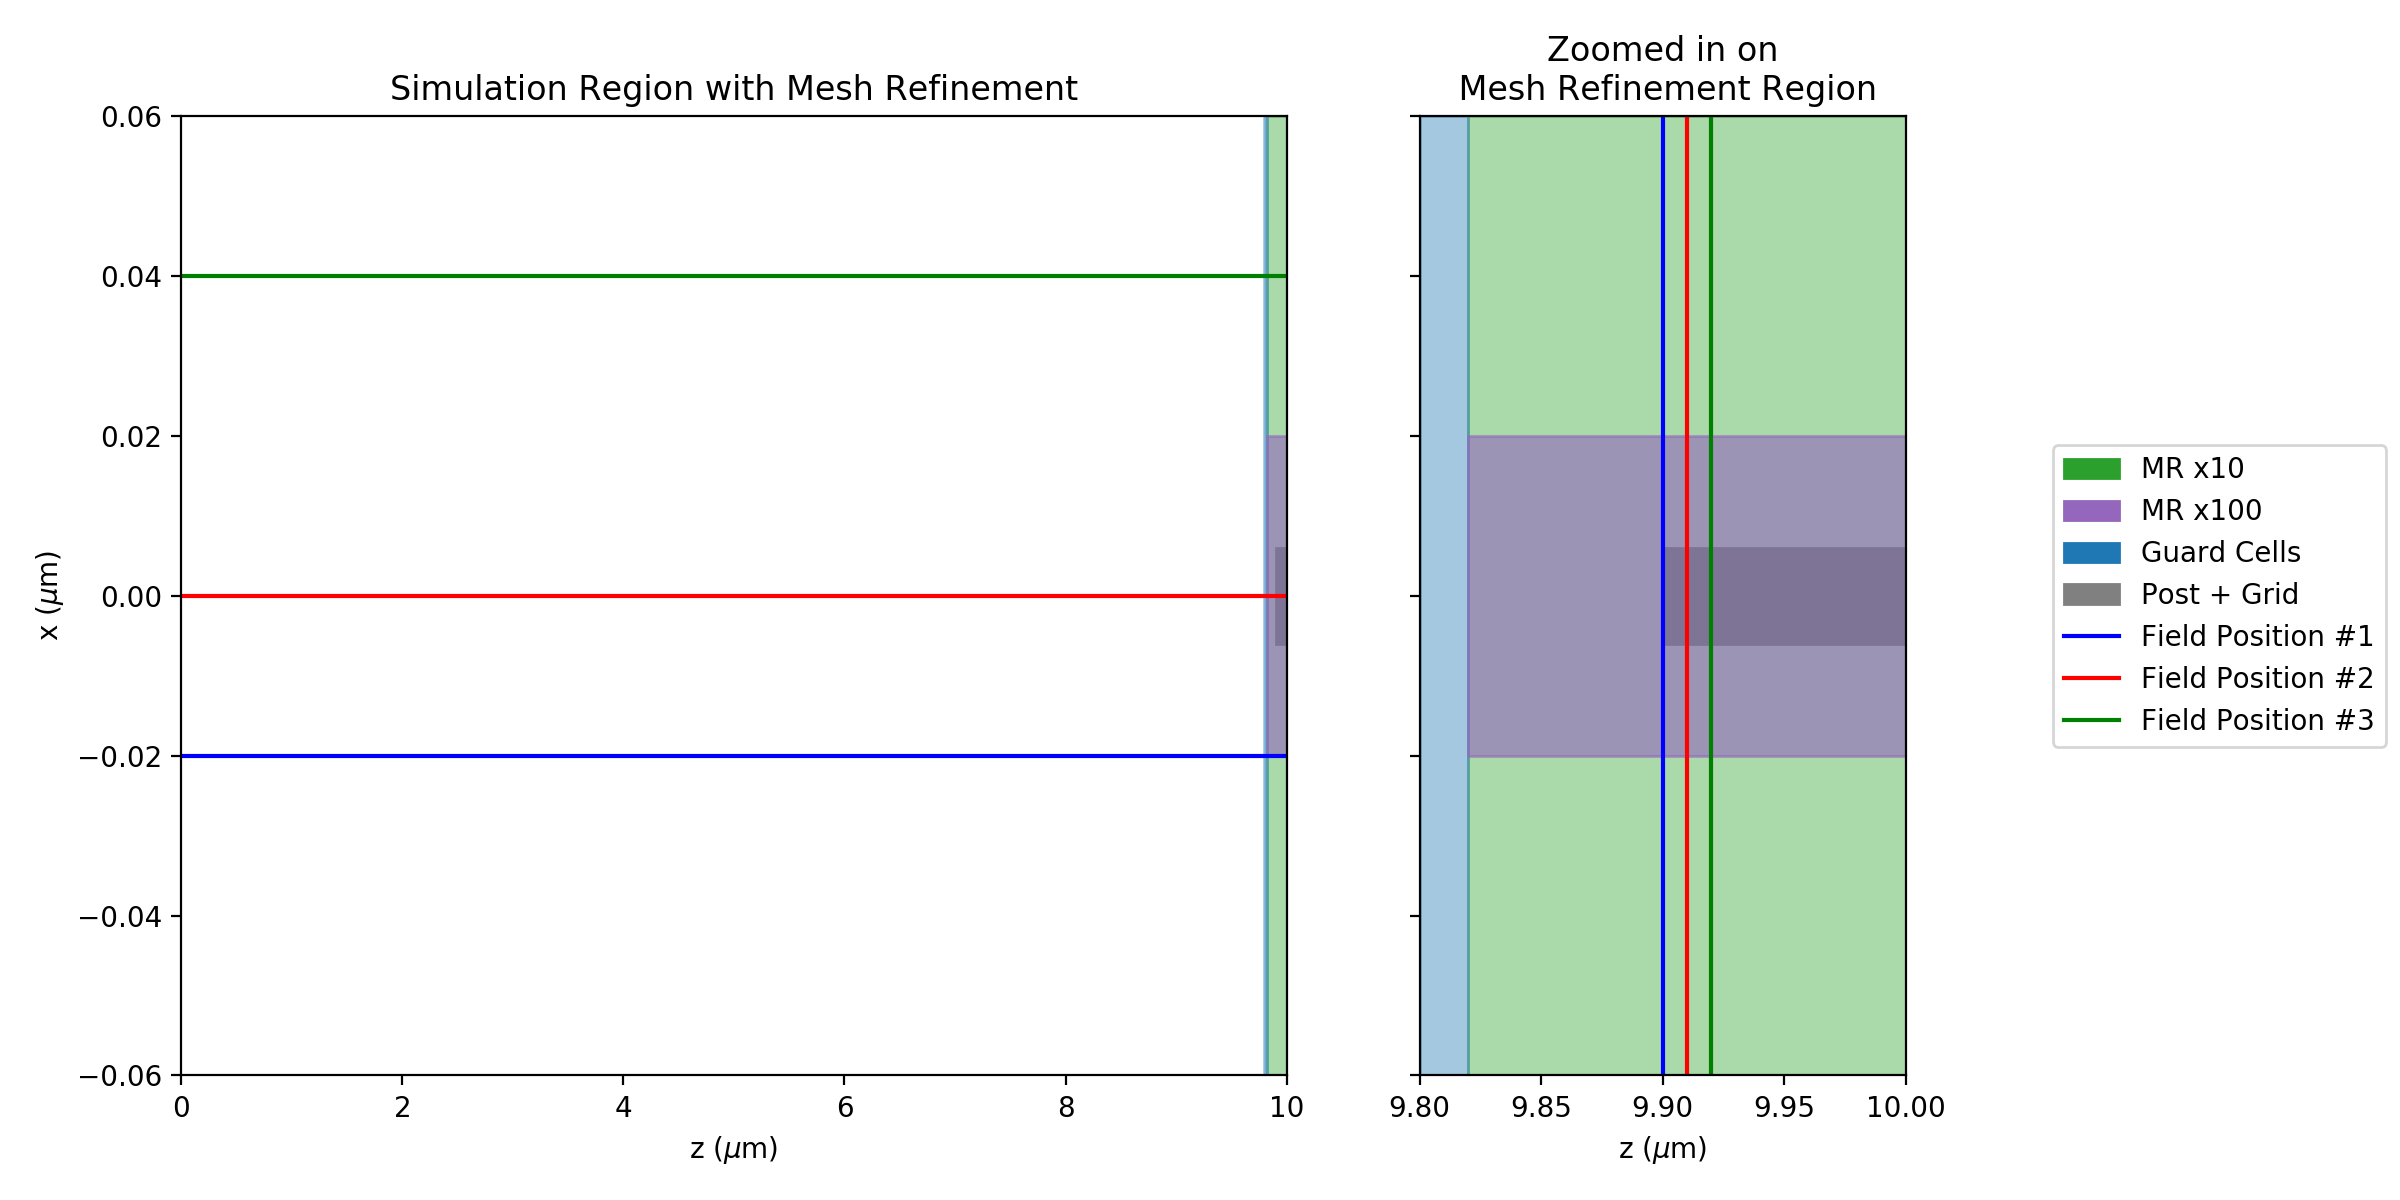

In [20]:
fig = plt.figure(figsize=(12,6))
# Set up plotting region
gs = gridspec.GridSpec(1, 15)
ax1 = plt.subplot(gs[0,0:8])
ax2 = plt.subplot(gs[0,8:12])
ax3 = plt.subplot(gs[0,12:13])

ax1.set_title("Simulation Region with Mesh Refinement")
ax2.set_title("Zoomed in on\n Mesh Refinement Region")

# Set plot scales and bounds
scale = 1e6
ax1.set_xlim(Z_MIN * scale, Z_MAX * scale)
ax1.set_ylim(X_MIN * scale, X_MAX * scale)

ax1.set_xlabel('z ($\mu$m)')
ax1.set_ylabel('x ($\mu$m)')

ax2.set_xlim(9.80, 10.0)
ax2.set_ylim(X_MIN * scale, X_MAX * scale)

ax2.set_xlabel('z ($\mu$m)')
ax2.set_yticklabels([])

xc = PLATE_SPACING - (column_length + grid_length)
yc = -column_width / 2.

# Add patches to represent conductors/dielectric regions
set_patch(ax1, xc, yc, (column_length + grid_length), column_width, 
              set_facecolor='grey',set_edgecolor='grey',set_alpha=1., scale=scale)
set_patch(ax2, xc, yc, (column_length + grid_length), column_width, 
              set_facecolor='grey',set_edgecolor='grey',set_alpha=1., scale=scale)

xc1 = PLATE_SPACING - 2 * column_length
yc1 = X_MIN

set_patch(ax1, xc1, yc1, 2 * (column_length + grid_length), (X_MAX - X_MIN), 
              set_facecolor='#2ca02c',set_edgecolor='#2ca02c',set_alpha=0.4, scale=scale)
set_patch(ax2, xc1, yc1, 2 * (column_length + grid_length), (X_MAX - X_MIN), 
              set_facecolor='#2ca02c',set_edgecolor='#2ca02c',set_alpha=0.4, scale=scale)

xc2 = PLATE_SPACING - 2 * column_length - guardz * (w3d.zmmax / w3d.nz)
yc2 = X_MIN

set_patch(ax1, xc2, yc1, (xc1 - xc2), (X_MAX - X_MIN), 
              set_facecolor='#1f77b4',set_edgecolor='#1f77b4',set_alpha=0.4, scale=scale)
set_patch(ax2, xc2, yc1, (xc1 - xc2), (X_MAX - X_MIN), 
              set_facecolor='#1f77b4',set_edgecolor='#1f77b4',set_alpha=0.4, scale=scale)

set_patch(ax1, xc1, -20e-9, 2 * (column_length + grid_length), 40e-9, 
              set_facecolor='#9467bd',set_edgecolor='#9467bd',set_alpha=0.6, scale=scale)
set_patch(ax2, xc1, -20e-9, 2 * (column_length + grid_length), 40e-9, 
              set_facecolor='#9467bd',set_edgecolor='#9467bd',set_alpha=0.6, scale=scale)


# Plot lines on plot that represent where the lineout plots of the fields are coming from
# Plot lines parallel to z
for xpos, cx in zip(x_positions, ['b', 'r', 'g']):
    ax1.plot(solverE.zmesh * scale, np.ones_like(solverE.zmesh) * xpos * scale, c=cx)
# Plot lines parallel to x
for zpos, cz in zip(z_positions, ['b', 'r', 'g']):
    ax2.plot(np.ones_like(solverE.xmesh) * zpos * scale, solverE.xmesh * scale, c=cz)

mr_0 = patches.Patch(color='#2ca02c', label='MR x10')
mr_1 = patches.Patch(color='#9467bd', label='MR x100')
guard1 = patches.Patch(color='#1f77b4', label='Guard Cells')
grid = patches.Patch(color='grey', label='Post + Grid')
e1 = mlines.Line2D([], [], color='b',label='Field Position #1')
e2 = mlines.Line2D([], [], color='r',label='Field Position #2')
e3 = mlines.Line2D([], [], color='g',label='Field Position #3')


ax3.legend(handles=[mr_0, mr_1, guard1, grid, e1, e2, e3],fontsize=10,loc=6)
ax3.axis('off')
plt.tight_layout()
plt.show()

### Above: User positions line along which they want to see the electric field data (E_x or E_z) or the potential.


## Load Field/Potential Diagnostic Data From Files

In [21]:
# Load parent fields
num_steps = '0' * (5 - len(str(top.it))) +str(top.it)
fielddata_path = 'diags/fields/electric/data{}.h5'.format(num_steps)
fielddata_file = os.path.splitext(os.path.split(fielddata_path)[1])[0]
step_number = int(findall(r'\d+', fielddata_file)[0])
data_efield = h5py.File(fielddata_path, 'r')

Ex = data_efield['data/%s/meshes/E' % (step_number)][0]
Ey = data_efield['data/%s/meshes/E' % (step_number)][1]
Ez = data_efield['data/%s/meshes/E' % (step_number)][2]

phi = data_efield['data/%s/meshes/phi'% (step_number)]
E = data_efield['data/%s/meshes/E' % (step_number)]

In [22]:
# Load child fields
num_steps = '0' * (5 - len(str(top.it))) +str(top.it)
fielddata_path = 'diags/fields/child0/data{}.h5'.format(num_steps)
fielddata_file = os.path.splitext(os.path.split(fielddata_path)[1])[0]
step_number = int(findall(r'\d+', fielddata_file)[0])
data_efield = h5py.File(fielddata_path, 'r')

child0_Ex = data_efield['data/%s/meshes/E' % (step_number)][0]
child0_Ey = data_efield['data/%s/meshes/E' % (step_number)][1]
child0_Ez = data_efield['data/%s/meshes/E' % (step_number)][2]

child0_phi = data_efield['data/%s/meshes/phi'% (step_number)]
child0_E = data_efield['data/%s/meshes/E' % (step_number)]

In [23]:
# Load child fields
num_steps = '0' * (5 - len(str(top.it))) +str(top.it)
fielddata_path = 'diags/fields/child1/data{}.h5'.format(num_steps)
fielddata_file = os.path.splitext(os.path.split(fielddata_path)[1])[0]
step_number = int(findall(r'\d+', fielddata_file)[0])
data_efield = h5py.File(fielddata_path, 'r')

child1_Ex = data_efield['data/%s/meshes/E' % (step_number)][0]
child1_Ey = data_efield['data/%s/meshes/E' % (step_number)][1]
child1_Ez = data_efield['data/%s/meshes/E' % (step_number)][2]

child1_phi = data_efield['data/%s/meshes/phi'% (step_number)]
child1_E = data_efield['data/%s/meshes/E' % (step_number)]

# Fields

### Plots of field data along the [Lineout Locations](#locations)

First plot $E_x$ field as a function of position along the x-axis at several locations along the z-axis.

Second plot $E_z$ field as a function of position along the z-axis at several locations along the x-axis.

<IPython.core.display.Javascript object>


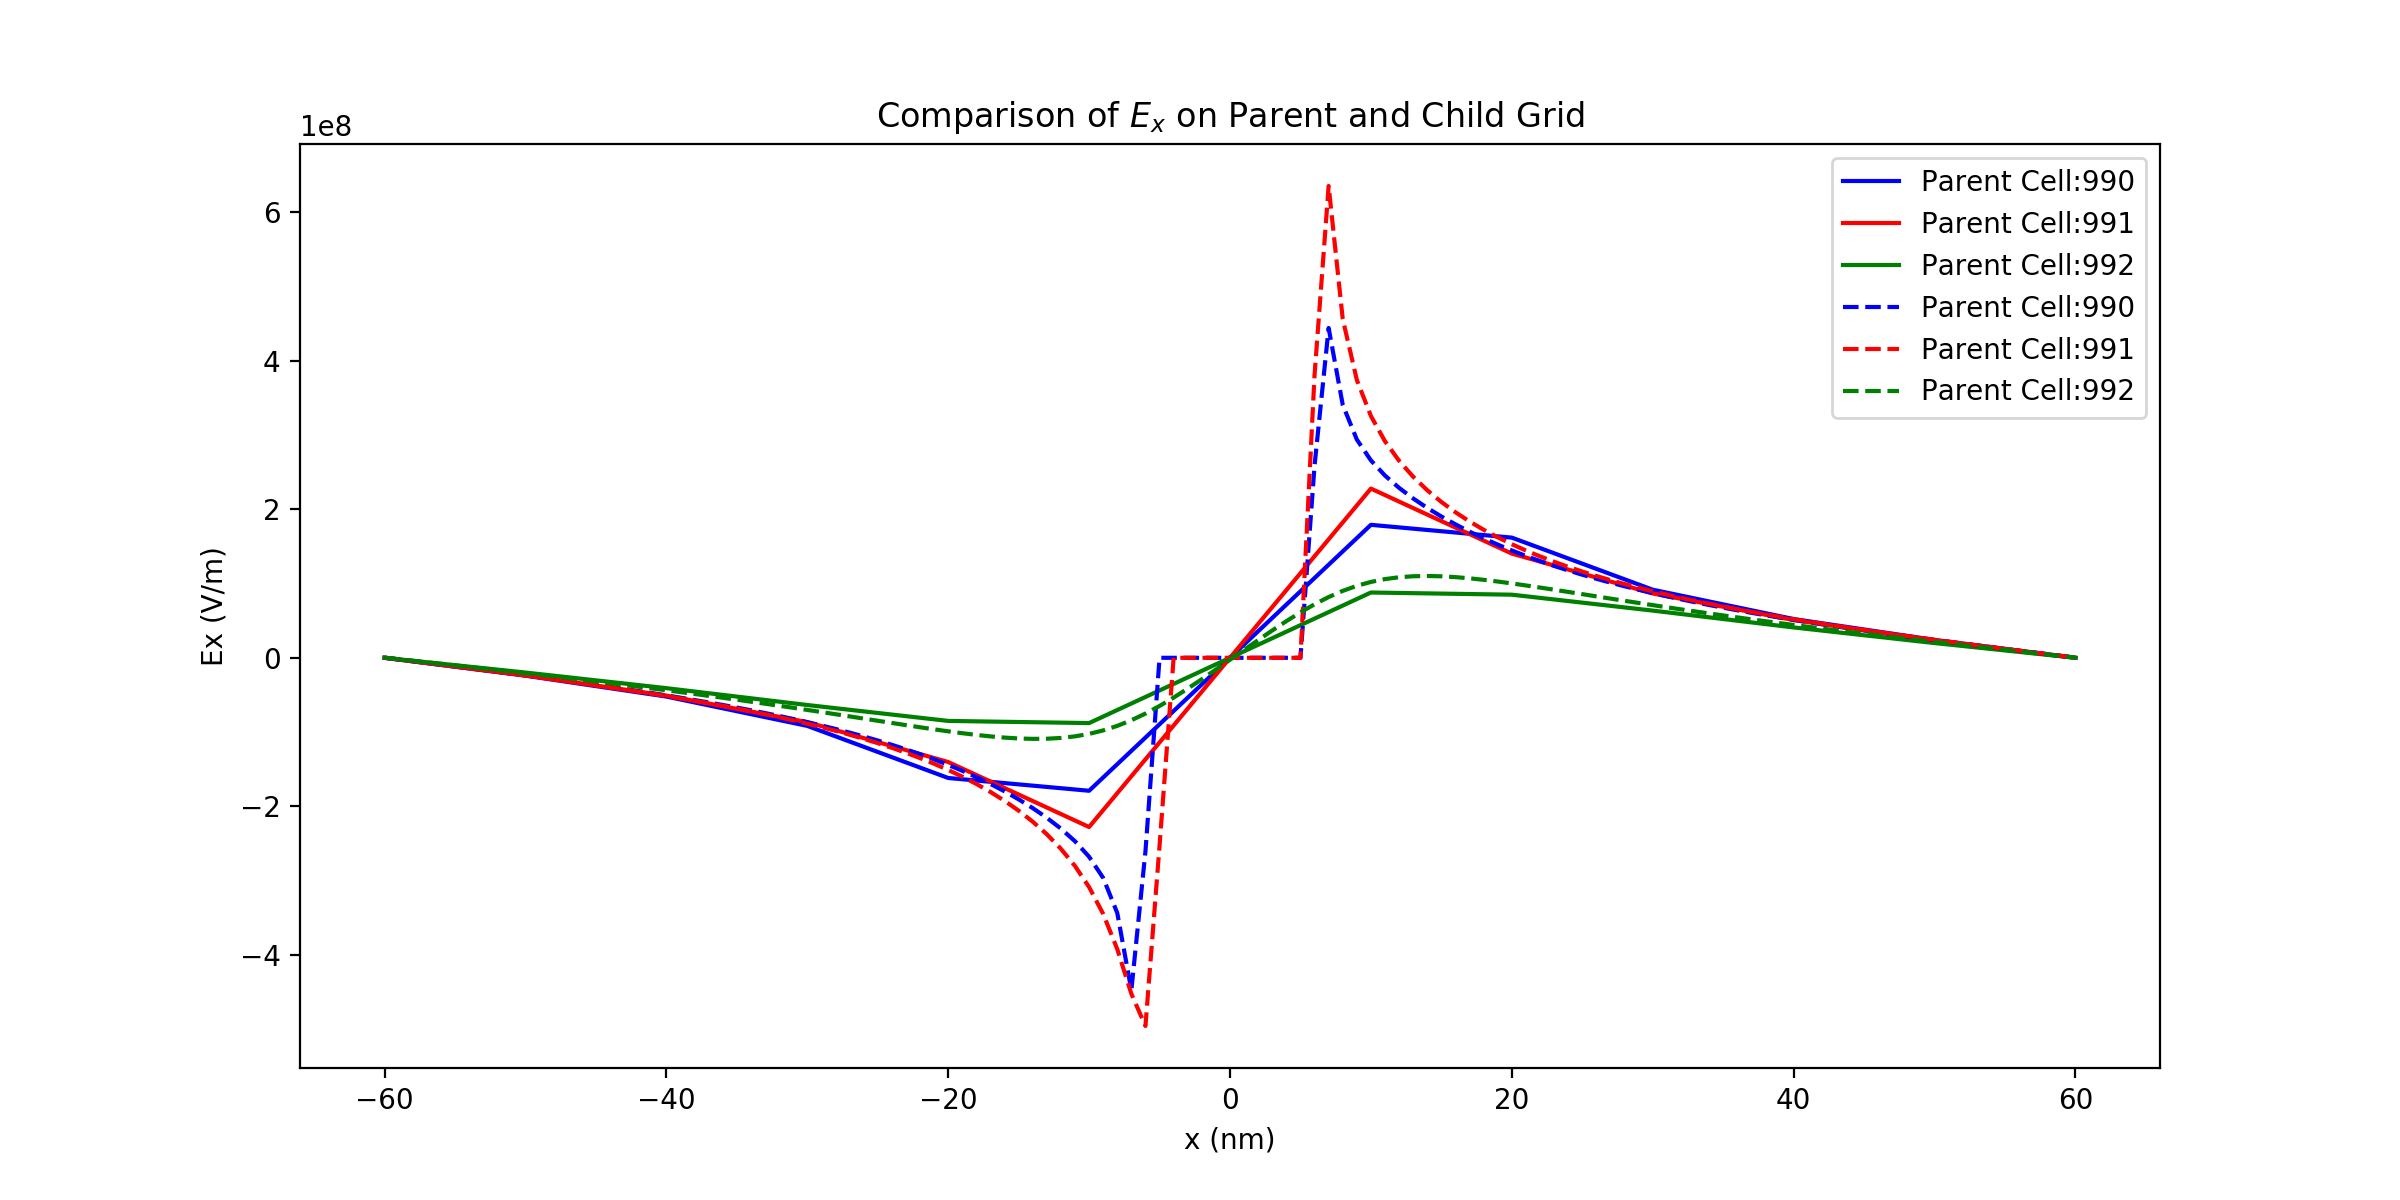

In [24]:
fig1 = plt.figure(figsize=(12,6))

plt.xlabel("x (nm)")
plt.ylabel("Ex (V/m)")
plt.title("Comparison of $E_x$ on Parent and Child Grid")

scale = 1e9

for zpos, c, cell in zip(z_positions, ['b', 'r', 'g'], [990, 991, 992]):
    index = return_index(solverE.zmmin, solverE.zmmax, np.size(solverE.zmesh), zpos)
    plt.plot(solverE.xmesh * scale, Ex[:, index], c=c, label='Parent Cell:' + '{}'.format(cell))

for zpos, c, cell in zip(z_positions, ['b', 'r', 'g'], [990, 991, 992]):
    index = return_index(child0.zmmin, child0.zmmax, np.size(child0.zmesh), zpos)
    plt.plot(child0.xmesh * scale, child0_Ex[:, index], '--',c=c, label='Parent Cell:' + '{}'.format(cell))

plt.legend(loc='best', fontsize=10)
plt.show()

<IPython.core.display.Javascript object>


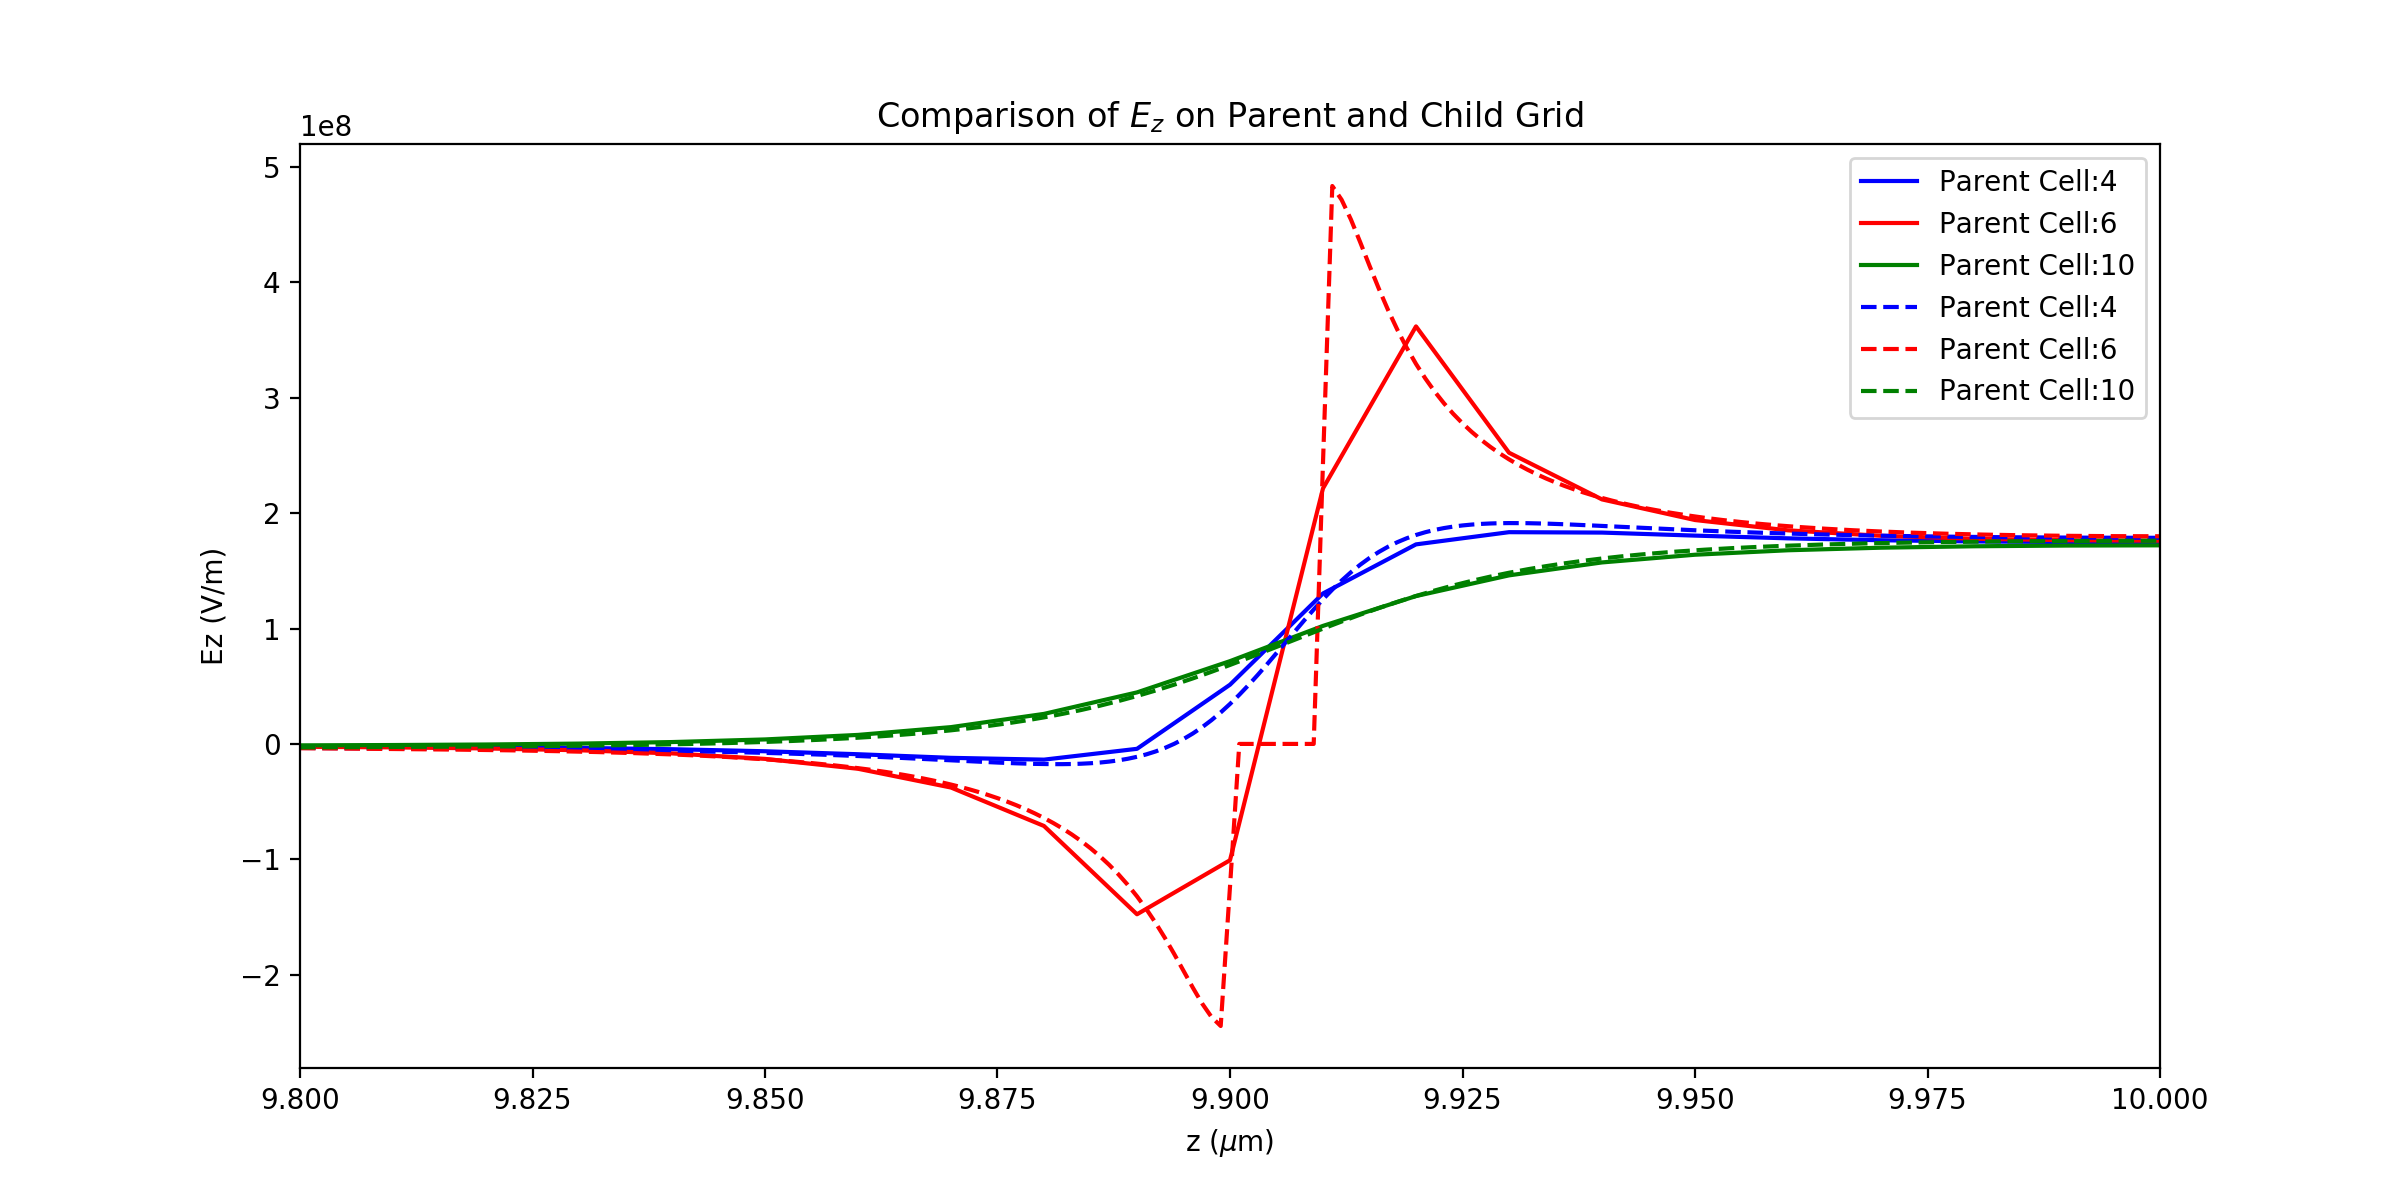

In [25]:
fig = plt.figure(figsize=(12,6))

plt.xlabel("z ($\mu$m)")
plt.ylabel("Ez (V/m)")
plt.title("Comparison of $E_z$ on Parent and Child Grid")

scale = 1e6

for xpos, c, cell in zip(x_positions, ['b', 'r', 'g'], [4, 6, 10]):
    index = return_index(solverE.xmmin, solverE.xmmax, np.size(solverE.xmesh), xpos)
    plt.plot(solverE.zmesh * scale, Ez[index, :], c=c, label='Parent Cell:' + '{}'.format(cell))

for xpos, c, cell in zip(x_positions, ['b', 'r', 'g'], [4, 6, 10]):
    index = return_index(child0.xmmin, child0.xmmax, np.size(child0.xmesh), xpos)
    plt.plot(child0.zmesh * scale, child0_Ez[index, :], '--',c=c, label='Parent Cell:' + '{}'.format(cell))

plt.xlim(9.80, 10.0)
    
plt.legend(loc='best', fontsize=10)

plt.show()

# Interactive Field Plots

In [26]:
# Lineout Axis: Axis the line intersects
# Lineout Intercept: Position the line intersects
# Field data: Choose to view Ex, Ez, or Potential along the line

plot1 = FieldLineout(solverE, E, phi)
plot1()

interactive(children=(Dropdown(description=u'Lineout Axis', options=OrderedDict([('x', 0), ('z', 1)]), value=0), Dropdown(description=u'Lineout Intercept', options=(-5.9999999999999995e-08, -4.9999999999999998e-08, -4.0000000000000001e-08, -2.9999999999999997e-08, -2e-08, -1.0000000000000004e-08, 0.0, 9.9999999999999969e-09, 1.9999999999999994e-08, 2.9999999999999991e-08, 3.9999999999999988e-08, 4.9999999999999985e-08, 5.9999999999999995e-08), value=-5.9999999999999995e-08), Dropdown(description=u'Field Data', options=OrderedDict([('E_x', 0), ('E_z', 1), ('Potential', 2)]), value=0), Output()), _dom_classes=('widget-interact',))